In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import sys
sys.path = [".."] + sys.path

In [4]:
import src.optimal_assignment as oa
import src.basic_assignment as ba

## Build a network of preferences

In [5]:
import hvplot.networkx as hvnx
import networkx as nx
import holoviews as hv

In [6]:
import names

In [7]:
grid_dim = 5
n_names_location = grid_dim**2

In [8]:
x = np.arange(grid_dim)
y = np.arange(grid_dim)
xx, yy = np.meshgrid(x, y)

even_points = np.stack([xx.ravel(), yy.ravel()]).T

In [9]:
np.random.seed(21)
observers = pd.DataFrame()
polling_station = pd.DataFrame()
past_names = []
for i in range(n_names_location):
    name = names.get_first_name()
    while name in past_names:
        name = names.get_first_name()
    past_names.append(name)
    observers = observers.append({
                                  'idx':i, 
                                  'observer': name, 
                                  'location': even_points[i] /1.5 + 0.75 
                                 }, ignore_index=True)
    polling_station = polling_station.append({
                                              'idx':i, 
                                              'polling_station': f'PollingStation_{i}', 
                                              'location': even_points[i]
                                             }, ignore_index=True)
    
polling_station['assigned_observer'] = np.random.choice(observers.observer.values, size = n_names_location, replace = False)

In [10]:
assigment = polling_station.merge(observers[['observer', 'location']], left_on='assigned_observer', right_on='observer', suffixes=("_ps", "_obs"))

In [11]:
data = np.zeros((n_names_location, 2, 2))
data[:, 0, :] = np.stack(assigment.location_ps.values)
data[:, 1, :] = np.stack(assigment.location_obs.values)

In [12]:
from matplotlib.collections import LineCollection

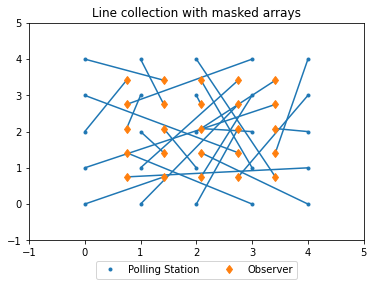

In [13]:
f, ax = plt.subplots()
line_segments = LineCollection(data, linestyle='solid')
ax.add_collection(line_segments)
ax.set_xlim(-1, 5)
ax.set_ylim(-1, 5)
ax.set_title('Line collection with masked arrays')
plt.plot(*np.stack(assigment.location_ps.values).T, ".", label = "Polling Station")
plt.plot(*np.stack(observers.location.values).T, "d", label = "Observer")
plt.legend(bbox_to_anchor = (0.5, -0.2), ncol = 2, loc = 'lower center')
plt.show()


In [14]:
def get_distance_df(observers, polling_station):
    """
    Given a dataset of observers and polling_stations, return a matrix od
    distances between them.
    
    Parameters
    ----------
    observers: pd.Dataframe
        A dataframe of observers. Should have `observer` and `location` as columns
    polling_station: pd.Dataframe
        A dataframe of polling_station. Should have `polling_station` and `location` as columns
        
    Returns
    -------
    distance_df: pd.Dataframe
        A dataframe of distances between all observers and polling_stations
    
    """
    
    obs_idx, poll_st_idx = np.meshgrid(np.arange(observers.shape[0]), np.arange(polling_station.shape[0]))
    distance_arr = polling_station['location'].values[poll_st_idx.ravel()] - observers['location'].values[obs_idx.ravel()]
    distance_arr = np.stack(distance_arr)
    
    distance_df = pd.DataFrame({'distance':np.linalg.norm(distance_arr, axis=1)})
    distance_df['observer_idx'] = obs_idx.ravel()
    distance_df['observer_name'] = observers.iloc[obs_idx.ravel()]['observer'].values
    distance_df['polling_station_idx'] = poll_st_idx.ravel()
    distance_df['polling_station'] = polling_station.iloc[poll_st_idx.ravel()]['polling_station'].values
    
    return distance_df

In [220]:
distance_df

distance  observer_idx observer_name  polling_station_idx  \
0    1.060660             0       Dorothy                    0   
1    1.602949             1        Andrew                    0   
2    2.214222             2        Steven                    0   
3    2.850439             3       Wendell                    0   
4    3.498015             4        Cherie                    0   
..        ...           ...           ...                  ...   
620  3.301935            20        Joseph                   24   
621  2.648375            21       Russell                   24   
622  2.003469            22       Gregory                   24   
623  1.379412            23     Elizabeth                   24   
624  0.824958            24           Ann                   24   

       polling_station  
0     PollingStation_0  
1     PollingStation_0  
2     PollingStation_0  
3     PollingStation_0  
4     PollingStation_0  
..                 ...  
620  PollingStation_24  
621  PollingStation_24  
622  PollingStation_24  
623  PollingStation_24  
624  PollingStation_24  

[625 rows x 5 columns]

## Build the raw graph

In [15]:
G_raw = nx.DiGraph()

for n in polling_station.assigned_observer.values:
    G_raw.add_node(n, node_type = 'observer')
for n in polling_station.polling_station.values:
    G_raw.add_node(n, node_type = 'poll_station')
    
pos = assigment.set_index('polling_station')['location_ps'].to_dict()
pos.update(assigment.set_index('assigned_observer')['location_obs'].to_dict())

for p in polling_station[['polling_station', 'assigned_observer']].itertuples():
    G_raw.add_edge(p.polling_station, p.assigned_observer, edge_type = 'allocated', distance = 1.0)

In [16]:
pos = assigment.set_index('polling_station')['location_ps'].to_dict()
pos.update(assigment.set_index('assigned_observer')['location_obs'].to_dict())

## Include distance 

In [17]:
def build_pref(G_raw, cycle_nodes, distance_df):
    
    distance_df = distance_df[~(distance_df.observer_name.isin(cycle_nodes) | distance_df.polling_station.isin(cycle_nodes))]
    G_pref = nx.DiGraph()
    G_pref.add_nodes_from(G_raw.nodes(data=True))
    G_pref.add_edges_from(G_raw.edges(data=True))
    all_pref_nodes = [(u, v) for (u, v, d) in G_pref.edges(data=True) if d.get('edge_type') != 'allocated']
    G_pref.remove_edges_from(all_pref_nodes)
    
    best_link = pd.DataFrame()
    for ps, df in distance_df.groupby('observer_name'):
        best_link = best_link.append(df.sort_values('distance').head(1))
        
    if len(best_link) > 0:
        G_pref.add_edges_from(best_link[['observer_name', 'polling_station']].itertuples(index=False, name=None))  
    
    return G_pref

In [18]:
distance_df = get_distance_df(observers, polling_station)
G_pref = build_pref(G_raw, [], distance_df)

In [19]:
observer_nodes = [n[0] for n in G_pref.nodes(data = True) if n[1]['node_type'] == 'observer']
polling_station_nodes = [n[0] for n in G_pref.nodes(data = True) if n[1]['node_type'] == 'poll_station']
allocated_edges = [(u, v) for (u, v, d) in G_pref.edges(data=True) if d.get('edge_type') == 'allocated']
pref_edges = [(u, v) for (u, v, d) in G_pref.edges(data=True) if d.get('edge_type') != 'allocated']

In [245]:
#edges_own_plot = hvnx.draw_networkx_edges(G_pref, pos,  edgelist = allocated_edges, alpha = 0.4, arrows = False,
#                         arrowsize=1, edge_width=2, height = 600, width = 600)
#edges_pref_plot = hvnx.draw_networkx_edges(G_pref, pos,  edgelist = pref_edges, alpha = 0.4, edge_color='red', 
#                         arrowhead_length=0.014, edge_width=2,) 
nodes_plot = hvnx.draw_networkx_nodes(G_pref, pos, node_color='node_type', cmap = 'Blues', height = 600, 
                                          width = 600, alpha = 0.7)

#edges_pref_plot * edges_own_plot * 
hvnx.save(nodes_plot, 'graph_layout.png')

:Graph   [start,end]

In [98]:
def draw_allocation(G_pref, pos, poll_stations_highlight = None, observers_to_highlight = None, 
                    edges_to_highlight = None, i = 0, ax = None):
    
    observer_nodes = [n[0] for n in G_pref.nodes(data = True) if n[1]['node_type'] == 'observer']
    polling_station_nodes = [n[0] for n in G_pref.nodes(data = True) if n[1]['node_type'] == 'poll_station']
    allocated_edges = [(u, v) for (u, v, d) in G_pref.edges(data=True) if d.get('edge_type') == 'allocated']
    pref_edges = [(u, v) for (u, v, d) in G_pref.edges(data=True) if d.get('edge_type') != 'allocated']

    if ax is None:
        f, ax = plt.subplots(figsize=(10, 10), frameon=False)
    else:
        f = ax.get_figure()
    
    nx.draw_networkx_edges(G_pref, pos,  edgelist = allocated_edges, alpha = 0.4, arrows = False,
                         arrowsize=1, width=2, ax = ax)
    nx.draw_networkx_edges(G_pref, pos,  edgelist = pref_edges, alpha = 0.4, edge_color='red', 
                             arrowsize=3, width=2, ax = ax) 
    nx.draw_networkx_nodes(G_pref, pos, nodelist=observer_nodes, node_color='white', edgecolors='blue', alpha = 0.7, ax = ax)
    nx.draw_networkx_nodes(G_pref, pos, nodelist=polling_station_nodes, node_color='white', node_shape='s', 
                           edgecolors='darkred', alpha = 0.7, ax = ax)
    
    ax.annotate(i, xy = (0.95, 0.95), xycoords = 'axes fraction')
    if poll_stations_highlight is not None:
        nx.draw_networkx_nodes(G_pref, pos, nodelist=poll_stations_highlight, node_color='firebrick', node_shape='s', 
                               edgecolors='darkred', ax = ax)
    if observers_to_highlight is not None:
        nx.draw_networkx_nodes(G_pref, pos, nodelist=observers_to_highlight, node_color='dodgerblue',
                               edgecolors='blue', ax = ax)
    if edges_to_highlight is not None:
        nx.draw_networkx_edges(G_pref, pos,  edgelist = edges_to_highlight, arrows = True,
                                 arrowsize=10, width=5, edge_color='lightgreen', ax = ax)
    
    ax.set_xbound(-0.5, 4.5)
    ax.set_ybound(-0.5, 4.5)
    
    return f


In [99]:
def resolve_cycle(G, edges):
    G.remove_edges_from(edges)
    new_edges = []
    for u, v in edges:
        if v.startswith("PollingStation"):
            G.add_edge(v, u, edge_type = 'allocated')
            new_edges.append((v, u))
    return G, new_edges

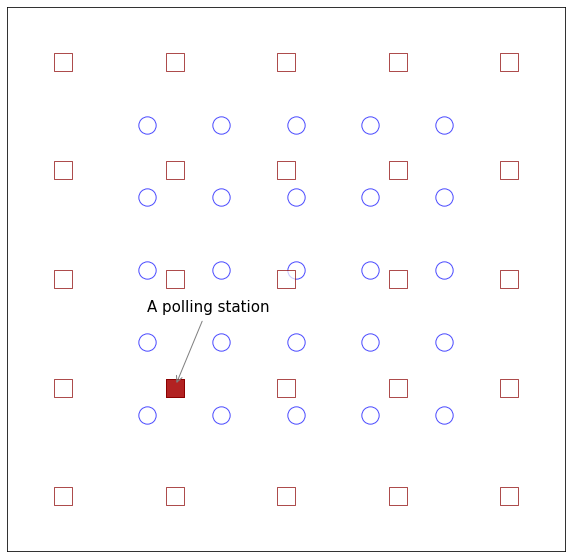

In [225]:
G_pref = build_pref(G_raw, [], distance_df)
edges = list(G_pref.edges)
G_pref.remove_edges_from(edges)
f = draw_allocation(G_pref, pos, i="")
ax = f.get_axes()
plt.annotate("A polling station", (1, 1), xytext = (0.75, 1.7), fontsize = 15,
                             arrowprops=dict(arrowstyle="->", 
                                            color="0.5",
                                            shrinkA=5, shrinkB=5,))
nx.draw_networkx_nodes(G_pref, pos, nodelist = ["PollingStation_6"], 
                               node_color='firebrick', node_shape='s', 
                               edgecolors='darkred', ax = ax[0] )
ax[0].set_xbound(-0.5, 4.5)
ax[0].set_ybound(-0.5, 4.5)
f.savefig(f"fig_0.png")
f.savefig(f"fig_1.png")
f.savefig(f"fig_2.png")

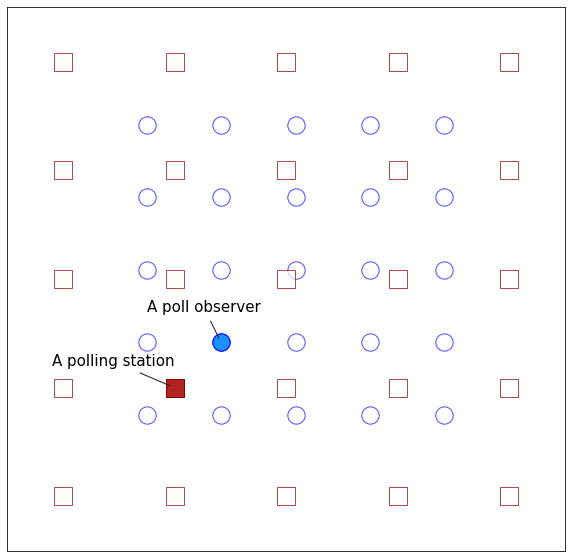

In [246]:
f = draw_allocation(G_pref, pos, i="")
ax = f.get_axes()
plt.annotate("A poll observer", (1/1.5 + 0.75, 1/1.5 + 0.75), xytext = (0.75, 1.7), fontsize = 15,
                             arrowprops=dict(arrowstyle="-", 
                                            color="0.1",
                                            shrinkA=5, shrinkB=5,))
nx.draw_networkx_nodes(G_pref, pos, nodelist = ["Ken"], 
                               node_color='dodgerblue',
                               edgecolors='blue', ax = ax[0])

plt.annotate("A polling station", (1, 1), xytext = (-0.1, 1.2), fontsize = 15,
                             arrowprops=dict(arrowstyle="-", 
                                            color="0.1",
                                            shrinkA=5, shrinkB=5,))
nx.draw_networkx_nodes(G_pref, pos, nodelist = ["PollingStation_6"], 
                               node_color='firebrick', node_shape='s', 
                               edgecolors='darkred', ax = ax[0] )

ax[0].set_xbound(-0.5, 4.5)
ax[0].set_ybound(-0.5, 4.5)

f.savefig("../../../../sidravi1.github.io/assets/20201113_fake_data.png")

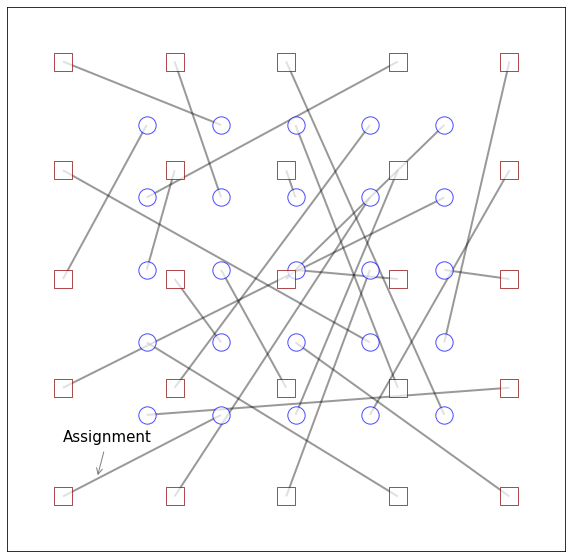

In [259]:
resolved_nodes = []
all_cycles = list(nx.simple_cycles(G_pref))
f = draw_allocation(G_raw, pos, i="")

ax = f.get_axes()
plt.annotate("Assignment", (0.3, 0.15), xytext = (0, 0.5), fontsize = 15,
                             arrowprops=dict(arrowstyle="->", 
                                            color="0.5",
                                            shrinkA=5, shrinkB=5,))


ax[0].set_xbound(-0.5, 4.5)
ax[0].set_ybound(-0.5, 4.5)
f.savefig("../../../../sidravi1.github.io/assets/20201113_assignment_raw.png")
#f.savefig(f"fig_3.png")

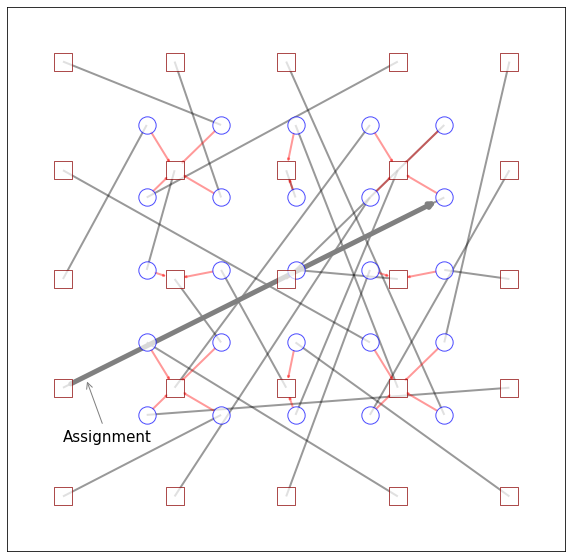

In [253]:
G_pref = build_pref(G_raw, [], distance_df)
resolved_nodes = []
all_cycles = list(nx.simple_cycles(G_pref))
f = draw_allocation(G_pref, pos, i="")

ax = f.get_axes()
plt.annotate("Assignment", (0.2, 1.1), xytext = (0, 0.5), fontsize = 15,
                             arrowprops=dict(arrowstyle="->", 
                                            color="0.5",
                                            shrinkA=5, shrinkB=5,))


nx.draw_networkx_edges(G_pref, pos,  edgelist = [("PollingStation_5", "Lindsey")], arrows = True,
                         arrowsize=10, width=5, edge_color='gray', ax = ax[0])

ax[0].set_xbound(-0.5, 4.5)
ax[0].set_ybound(-0.5, 4.5)
f.savefig(f"fig_6.png")
f.savefig(f"fig_7.png")
f.savefig(f"fig_8.png")
#f.savefig(f"fig_3.png")

In [217]:
G_full = nx.DiGraph()
G_full.add_nodes_from(G_raw.nodes(data=True))
for x in distance_df[['polling_station', 'observer_name', 'distance']].itertuples(index = False, name=None):
    G_full.add_edge(x[1], x[0], distance = x[2])

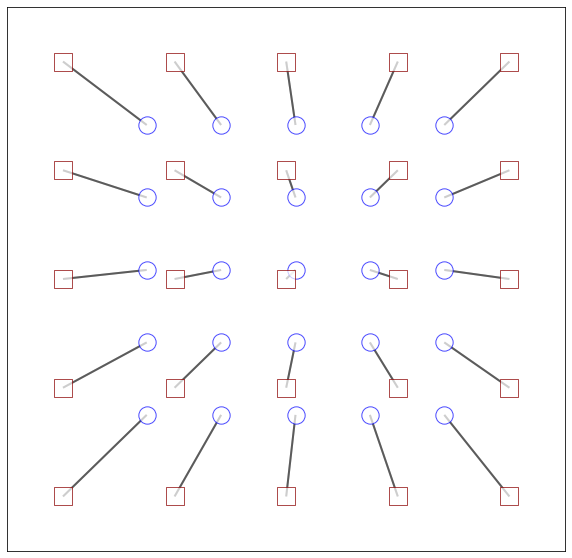

In [251]:
from networkx.algorithms.bipartite.matching import minimum_weight_full_matching

observer_nodes, _ = nx.bipartite.sets(G_full)
optimal_matching = minimum_weight_full_matching(G_full, top_nodes = observer_nodes, weight='distance')

G_optimal = nx.DiGraph()
G_optimal.add_nodes_from(G_raw.nodes(data=True))
G_optimal.add_edges_from(zip(optimal_matching.keys(),optimal_matching.values()), edge_type = 'allocated')

f = draw_allocation(G_optimal, pos, i="")
f.savefig("../../../../sidravi1.github.io/assets/20201113_optimal_match.png")          

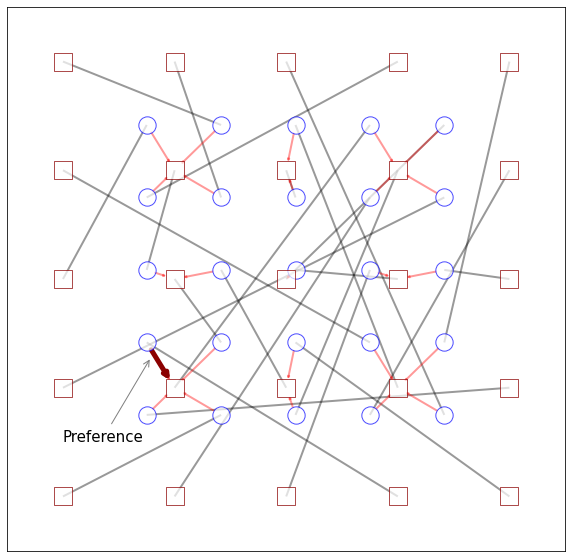

In [190]:
G_pref = build_pref(G_raw, [], distance_df)
resolved_nodes = []
all_cycles = list(nx.simple_cycles(G_pref))
f = draw_allocation(G_pref, pos, i="")

ax = f.get_axes()
plt.annotate("Preference", (0.8, 1.3), xytext = (0, 0.5), fontsize = 15,
                             arrowprops=dict(arrowstyle="->", 
                                            color="0.5",
                                            shrinkA=5, shrinkB=5,))


nx.draw_networkx_edges(G_pref, pos,  edgelist = [("Catherine", "PollingStation_6")], 
                         arrows = True,
                         arrowsize=10, width=5, edge_color='darkred', ax = ax[0])

ax[0].set_xbound(-0.5, 4.5)
ax[0].set_ybound(-0.5, 4.5)

f.savefig(f"fig_9.png")
f.savefig(f"fig_10.png")
f.savefig(f"fig_11.png")

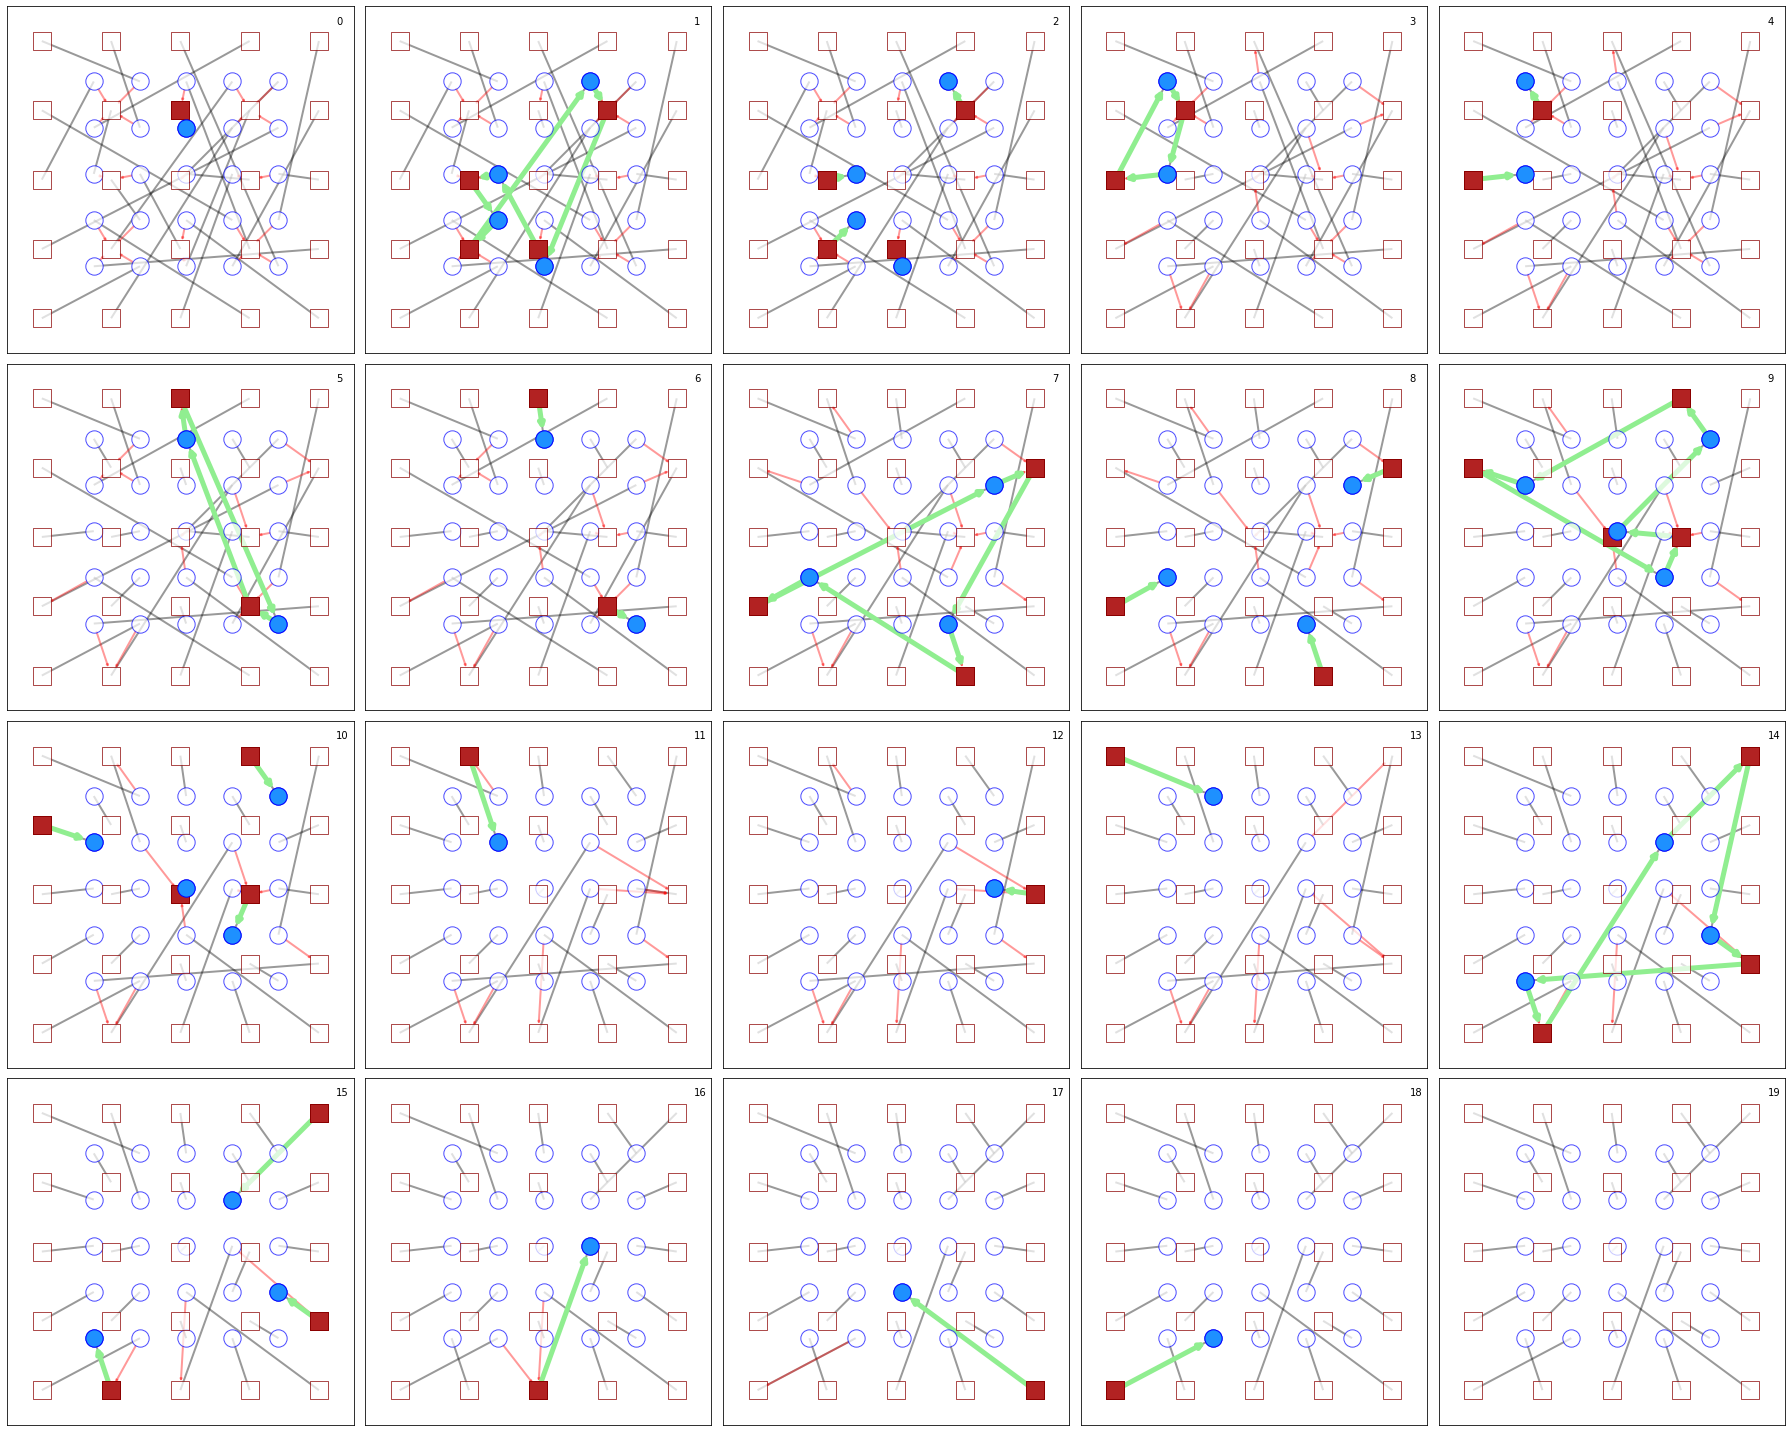

In [262]:
G_pref = build_pref(G_raw, [], distance_df)
resolved_nodes = []
all_cycles = list(nx.simple_cycles(G_pref))

fig, axes = plt.subplots(4, 5, figsize=(25,20))
all_axes = axes.ravel()

i = 0            
while len(all_cycles) > 0:
    for cycle in nx.simple_cycles(G_pref):
        if len(cycle) == 2:
            G_pref, new_edges = resolve_cycle(G_pref, [(cycle[1], cycle[0]),(cycle[0], cycle[1])])
            if cycle[0].startswith("PollingStation"):
                poll_node, obs_node = cycle
            else:
                obs_node, poll_node = cycle
            ax = all_axes[i]
            f = draw_allocation(G_pref, pos, [poll_node], [obs_node], new_edges, i, ax)
            f.savefig(f"fig_{i}.png")
            i += 1
        else:
            edges = list(zip(cycle[:-1], cycle[1:])) + [(cycle[-1], cycle[0])]
            poll_nodes = [x for x in cycle if x.startswith("PollingStation")]
            obs_nodes = [x for x in cycle if not x.startswith("PollingStation")]
            ax = all_axes[i]
            f = draw_allocation(G_pref, pos, poll_nodes, obs_nodes, edges, i, ax)
            f.savefig(f"fig_{i}.png")
            i += 1
            G_pref, new_edges = resolve_cycle(G_pref, edges)
            ax = all_axes[i]
            f = draw_allocation(G_pref, pos, poll_nodes, obs_nodes, new_edges, i, ax)
            #f.savefig(f"fig_{i}.png")
            i += 1
        resolved_nodes += cycle
    G_pref = build_pref(G_pref, resolved_nodes, distance_df)
    all_cycles = list(nx.simple_cycles(G_pref))

ax = all_axes[i]
f = draw_allocation(G_pref, pos, i = i, ax = ax)
f.savefig(f"fig_{i}.png")
#all_axes[-1].remove()
plt.tight_layout()


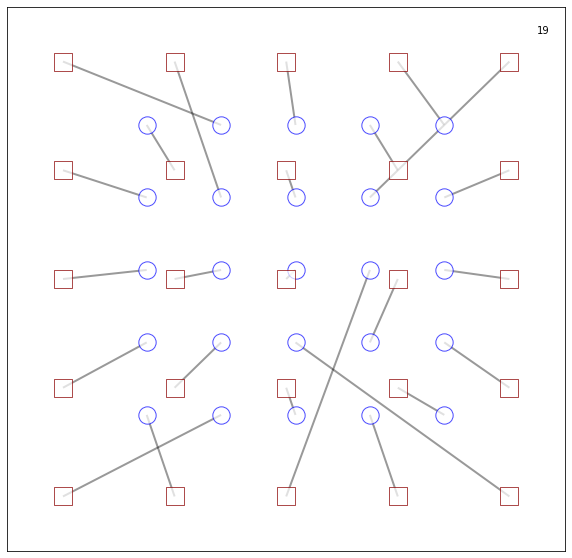

In [266]:
f = draw_allocation(G_pref, pos, i = i)
f.savefig(f"../../../../sidravi1.github.io/assets/20201113_pareto_optimal.png")

In [277]:
def graph_generator(G_pref, ax):
    for cycle in nx.simple_cycles(G_pref):
        if len(cycle) == 2:
            G_pref, new_edges = resolve_cycle(G_pref, [(cycle[1], cycle[0]),(cycle[0], cycle[1])])
            if cycle[0].startswith("PollingStation"):
                poll_node, obs_nodes = cycle
            else:
                obs_nodes, poll_node = cycle
                
            out = draw_allocation(G_pref, pos, [poll_node], [obs_nodes], new_edges, ax = ax);
        else:
            edges = list(zip(cycle[:-1], cycle[1:])) + [(cycle[-1], cycle[0])]
            poll_nodes = [x for x in cycle if x.startswith("PollingStation")]
            obs_nodes = [x for x in cycle if not x.startswith("PollingStation")]
            out = draw_allocation(G_pref, pos, poll_nodes, obs_nodes, edges, ax = ax)
            G_pref, new_edges = resolve_cycle(G_pref, edges)
            out = draw_allocation(G_pref, pos, poll_nodes, obs_nodes, new_edges, ax = ax)
        
        yield G_pref, cycle

def update(num):
    global G_pref, resolved_nodes, ax
    
    ax.clear()
    G = graph_generator(G_pref, ax)
    resolved_nodes += cycle
    G_pref = build_pref(G_pref, resolved_nodes, distance_df)
    all_cycles = list(nx.simple_cycles(G_pref))
    
    ax.set_title("Frame %d:    "%(num+1) , fontweight="bold")

    

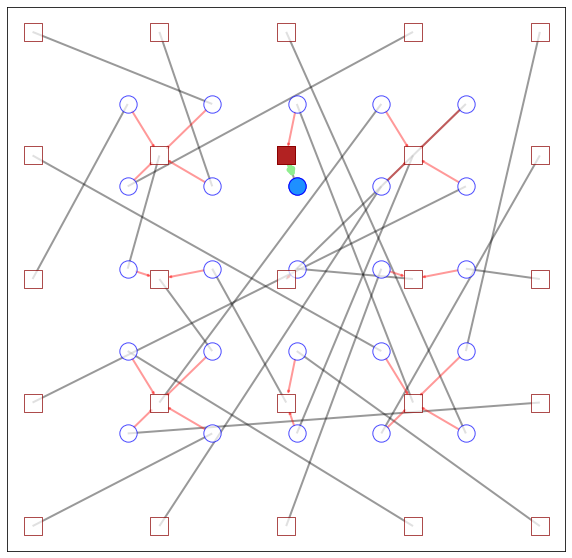

In [312]:
fig, ax = plt.subplots(figsize=(10,10))
G_pref = build_pref(G_raw, [], distance_df)
resolved_nodes = []
g = graph_generator(G_pref, ax)
J, _ = next(g)


In [314]:
J, cycle = next(g)

StopIteration: 

In [311]:
from matplotlib import animation
from IPython.display import HTML

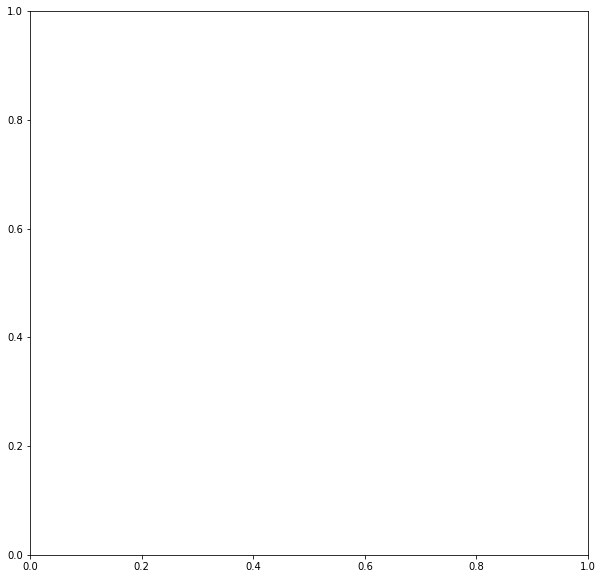

In [282]:
fig, ax = plt.subplots(figsize=(10,10))

G_pref = build_pref(G_raw, [], distance_df)
resolved_nodes = []
all_cycles = list(nx.simple_cycles(G_pref))

ani = animation.FuncAnimation(fig, update, frames=6, interval=1000);
#plt.show()

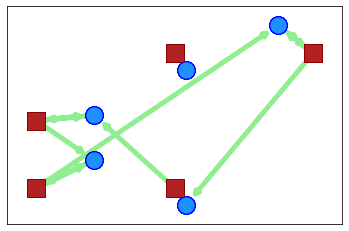

In [263]:
HTML(ani.to_jshtml())

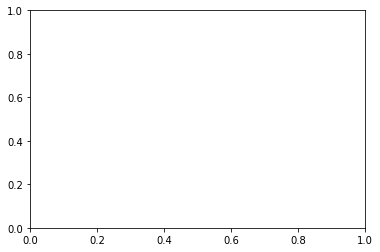

In [237]:
f, ax = plt.subplots()

In [239]:
nx.draw(H, ax = ax)